In [23]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [24]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

Downloading a sample of MNIST that contains images of just 3's and 7's

It is split into two folders train/3 and train/7

In [25]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

Now we're going to create a tensor containing all of the 3s stacked together, and another for the 7s

In [26]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

To show an image from a tensor, we can use fastai's built-in method called show_image()

<Axes: >

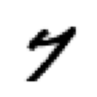

In [27]:
show_image(seven_tensors[1])

Now we need to combine all the images into a 3-dimensional tensor and stakc them into a single one using PyTorch's stack function.

<Axes: >

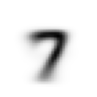

In [28]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

mean7 = stacked_sevens.mean(0)
mean3 = stacked_threes.mean(0)

show_image(mean7)

At this stage, we need to come up with a way of finding out the distance between a test digit and the ideal one. We can do this either using the mean absolute difference (L1) or using root mean squared error (L2)

In [29]:
a_3 = stacked_threes[1]

a_7 = stacked_sevens[1]

dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

dist_7_abs = (a_7 - mean7).abs().mean()
dist_7_sqr = ((a_7 - mean7)**2).mean().sqrt()

dist_3_abs, dist_3_sqr, dist_7_abs, dist_7_sqr

(tensor(0.1114), tensor(0.2021), tensor(0.1304), tensor(0.2585))

PyTorch also offers these distance measuring techniques as loss functions (F is in placement of torch.nn.functional)

In [30]:
F.l1_loss(a_3, mean3), F.mse_loss(a_3, mean3)

(tensor(0.1114), tensor(0.0408))

Now, we'll create the validation set by turning all images into a 3-dimensional tensor and stack them into a single one like we did before. 

In [31]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls().sorted()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls().sorted()])

valid_3_tens = valid_3_tens.float()/255
valid_7_tens = valid_7_tens.float()/255

Now, we'll turn mse into its own function

Note: we use mean((-1,-2)) because we want to take the mean across the last two dimensions (height and width) so that we take the mean of all pixels and end up with a single value.

In [32]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(valid_3_tens, mean3)

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

With this distance function , we can create the is_3 function which uses the following logic:
    - If the digit is lower in distance to a 3 than to a 7, then return that it's a 3.

In [33]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

With the is_3() function in place, now we want to see how accurate our current method is. Since PyTorch allows us to use casting, we can turn the boolean value of True/False to 1.0/0.0

To calculate the accuracy, we just take the average of the is_3() function casted to a float. When applying this to the digit 7, we have to take its inverse.

In [34]:
accuracy_3 = is_3(valid_3_tens).float().mean()
accuracy_7 = 1 - is_3(valid_7_tens).float().mean()

accuracy_3, accuracy_7, (accuracy_3 + accuracy_7)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

### Now, we're going to use a neural network on this dataset to come up with a model that will automatically improve itself.

The first thing we need to do is combine the `stacked_3s` and `stacked_7s` into one tensor. Each image in this tensor also needs to be converted into a vector of 784 pixels. 

This massive tensor will become our training set.

In [35]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Then we need to come up with a tensor containing the corresponding labels to our training set

In [36]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

Now that we have the data and corresponding labels, we create a dataset as required by PyTorch where it returns a tuple (data, label) when indexed

In [37]:
dset = zip(train_x, train_y)

We then also create the validation dataset using the same method as before:

In [38]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Finally we can start our 7 step process for SGD. So were going to initialize random weights for every pixel and also create a bias too:

In [39]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))
bias = init_params(1)

2. Now we're going to make a prediction for a single image

In [40]:
(train_x[0]*weights.T).sum() + bias

tensor([14.0882], grad_fn=<AddBackward0>)

This looks great. So now we're going to make predictions on all the images in the training set. 

We don't want to use a for loop because that would mean using the CPU to create the predictions = SLOW, BAD

So instead we use the `@` operator to have the GPU perform matrix multiplication. We'll define this in a function because the course tells us to.

In [41]:
def linear1(xb): return xb @ weights + bias
preds = linear1(train_x)
preds

tensor([[14.0882],
        [13.9915],
        [16.0442],
        ...,
        [ 1.2085],
        [ 1.7146],
        [ 2.6879]], grad_fn=<AddBackward0>)

Next we determine how accurate our predictions our with our current parameters

In [42]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [43]:
corrects.float().mean().item()

0.5642949342727661

Awesome, with this accuracy in mind we now have to come up with the best loss function. We can't use accuracy as a loss function because it usually doesn't improve with small changes to our weights. The only times it improves is when there is a larger proportion of correct images. This happens when a prediction flips from wrong to right and vice versa. 

To improve our parameters we need meaningful gradients to work with. We can't use accuracy as a ways to calculate gradient because it would yield a gradient of 0, or infinity when a weight causes a prediction to cross the decision threshold of 0.5.

Basically, we need continuous data to bring us to allow us to create a true gradient where bad predictions are penalized more (the loss goes down) and good predictions are rewarded more (the loss increases).

This loss function, called `mnist_loss` takes two arguments:

`prds`: A rank-1 tensor containing predicted probabilties that an image is a 3 (0 ... 1)

`trgts`: A rank-1 tensor containing the actual label for the image (0,1)

In [61]:
# EXAMPLE
trgts   = tensor([1,0,1])
prds    = tensor([0.9, 0.4, 0.2])

def mnist_loss(prds, trgts):
    return torch.where(trgts==1, 1-prds, prds).mean()

loss1 = mnist_loss(prds, trgts)
loss2 = mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

loss1, loss2

(tensor(0.4333), tensor(0.2333))

This is a good first start at our loss function because when we change our prediction for the one "false" target, the loss goes down.

The major problem with our current implementation of the loss function is that it assumes that predictions will always between 0 and 1.

So now we will implement the sigmoid function that will ensure that our predictions will always be between 0 and 1.

At its core, this is the sigmoid function:

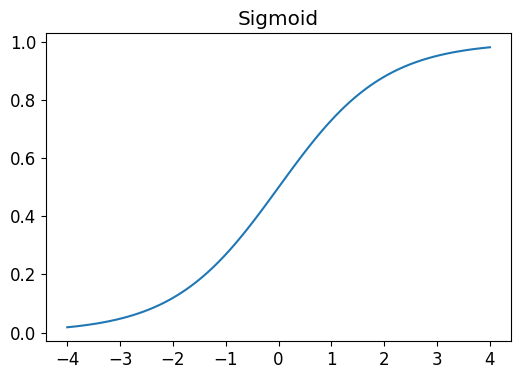

In [59]:
def sigmoid(x): return 1 / (1+torch.exp(-x))
plot_function(torch.sigmoid, title="Sigmoid", min=-4, max=4)

Now that we have a way of ensuring our predictions will always be between 0 and 1, let's use PyTorch's version of the sigmoid function (since it is optimized for cuda) into our `mnist_loss` function:

In [60]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

loss1 = mnist_loss(prds, trgts)
loss2 = mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

loss1, loss2

(tensor(0.4460), tensor(0.3993))